# MNIST with PyTorch

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**STEPS:**  
1. Convert data to correct images size
2. Create TrainLoader instance
3. Define model
4. Define hyperparameters
5. Train model
5. Test the model

## Load data and transform it to correct input shape

In [47]:
# Load the dataset
df = pd.read_csv("../data/train.csv")
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
df.shape

(42000, 785)

In [49]:
def convert_df_to_xy(df: pd.DataFrame) -> torch.IntTensor and torch.IntTensor:
    """Converts a Pandas DataFrame to 2 torch.IntTensor (x & y) so that you can later apply any function.
    The df needs to have shape (N, 785) where N: number of samples and 785: target + 784 pixels (28x28)

    Args:
        df (pd.DataFrame): The images data you will work with

    Returns:
        torch.IntTensor: x
        torch.IntTensor: y
    """

    number_of_samples = df.shape[0]
    X_train = None
    y_train = None
    
    # get the labels
    labels = df['label'].to_numpy()
    y_train = torch.Tensor(labels).reshape(number_of_samples, 1)

    # convert the rest of dataframe to correct image size (28x28)
    pixels = df[[col for col in df.columns if col != 'label']].to_numpy()
    X_train = torch.Tensor(pixels).reshape(number_of_samples, 1, 28, 28)

    return X_train, y_train



In [50]:
X_train, y_train = convert_df_to_xy(df=df)

print(f"y_train shape: {y_train.shape}")
print(f"X_train shape: {X_train.shape}")

y_train shape: torch.Size([42000, 1])
X_train shape: torch.Size([42000, 1, 28, 28])


### Plot one image to see if it is correct

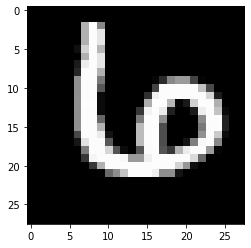

In [51]:
image_to_plot = 756

# plot the sample
fig = plt.figure
plt.imshow(X_train[image_to_plot][0], cmap='gray')
plt.show()

## Create train DataLoader

In [52]:
batch_size = 256

# create trainning dataset
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)

# create DataLoader
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

## Create Model class

In [53]:
class Conv2dSame(torch.nn.Conv2d):

    def calc_same_pad(self, i: int, k: int, s: int, d: int) -> int:
        return max((math.ceil(i / s) - 1) * s + (k - 1) * d + 1 - i, 0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        ih, iw = x.size()[-2:]

        pad_h = self.calc_same_pad(i=ih, k=self.kernel_size[0], s=self.stride[0], d=self.dilation[0])
        pad_w = self.calc_same_pad(i=iw, k=self.kernel_size[1], s=self.stride[1], d=self.dilation[1])

        if pad_h > 0 or pad_w > 0:
            x = F.pad(
                x, [pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2]
            )
        return F.conv2d(
            x,
            self.weight,
            self.bias,
            self.stride,
            self.padding,
            self.dilation,
            self.groups,
        )

In [58]:
class Model(nn.Module):

    def __init__(self):
        super().__init__()
        
        # in_features = channels * height * width
        self.in_features = 1 * 28 * 28

        # out_features = 1 number out of 10 numbers
        self.out_features = 1

        layer_list = [
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
            nn.ReLU(),
            Conv2dSame(in_channels=32, out_channels=32, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
            nn.ReLU(),
            Conv2dSame(in_channels=64, out_channels=64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            
            nn.Flatten(),
            nn.Linear(in_features=1024, out_features=128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(p=0.4),
            nn.Linear(in_features=128, out_features=10),
            nn.Softmax()
        ]
        self.layers = nn.Sequential(*layer_list)


    def forward(self, x):
        return self.layers(x)

In [59]:
model = Model()
model

Model(
  (layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): Conv2dSame(32, 32, kernel_size=(5, 5), stride=(2, 2))
    (5): ReLU()
    (6): Dropout(p=0.4, inplace=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU()
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU()
    (11): Conv2dSame(64, 64, kernel_size=(5, 5), stride=(2, 2))
    (12): ReLU()
    (13): Dropout(p=0.4, inplace=False)
    (14): Flatten(start_dim=1, end_dim=-1)
    (15): Linear(in_features=1024, out_features=128, bias=True)
    (16): ReLU()
    (17): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (18): Dropout(p=0.4, inplace=False)
    (19): Linear(in_features=128, out_features=10, bias=True)
    (20): Softmax(dim=None)
  )
)

## Define hyperparameters

In [60]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

## Train the model

In [65]:
epochs = 10
losses = []

for epoch in range(epochs):

    for i, (images, labels) in enumerate(train_dataloader):
        y_pred = model(images)
        loss = criterion(y_pred, labels.flatten().long())
        losses.append(loss.item())

        if i % 10 == 0:
            print(f"epoch: {epoch}      batch: {i}     loss: {loss.item()}")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

/Users/pablo/Desktop/dev/kaggle/mnist/venv/lib/python3.9/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch: 0      batch: 0     loss: 1.511735439300537
epoch: 0      batch: 10     loss: 1.4936037063598633
epoch: 0      batch: 20     loss: 1.5161073207855225
epoch: 0      batch: 30     loss: 1.5132595300674438
epoch: 0      batch: 40     loss: 1.497671365737915
epoch: 0      batch: 50     loss: 1.5034197568893433
epoch: 0      batch: 60     loss: 1.4859261512756348
epoch: 0      batch: 70     loss: 1.4900715351104736


KeyboardInterrupt: 